<a href="https://colab.research.google.com/github/hughes28/Seq2SeqNeuralMachineTranslator/blob/master/Seq2SeqEnglishtoDutchTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# English-to-Dutch Neural Machine Translation via Seq2Seq Architecture

## Background

### Neural machine translation is the ability for neural networks to predict the likelihood of a given sequence of words. A popular architecture used to do this is Seq2Seq. It consists of an encoder/decoder system which trains on English sentences and English word embeddings (represents word relations). The encoder model will go through each part of the numerical input sequence and generate an initial "state" to be used for the decoder. The state includes information about the sequence itself and the relation between the words. The decoder model takes this information in and begins to predict what the output would be using the state information and the "begin" token that is used to indicate the start of the sentence. It continuously loops through predicted words until it reaches an "end" token where it stops automatically. The predicted words are then grouped together and returned as a string. This following script details the data processing, accuracy determination, model generation, and sentence translation for a standard Seq2Seq architecture consisting of two long short-term memory (LSTM) networks based on recurrent neural networks (RNN).

##1. Create sentence data

### 1.1. Upload dataset

In [ ]:
# Source of dataset: http://www.manythings.org/anki/
# Source of word pre-trained word embeddings: https://nlp.stanford.edu/projects/glove/
# Files are uploaded to Google Drive and referenced using google.colab.

import os
from google.colab import drive

drive.mount("/content/gdrive")
sentences_file_path = '/content/gdrive/My Drive/LanguageData/nld.txt'
embeddings_file_path = '/content/gdrive/My Drive/LanguageData/glove.6B.100d.txt'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 1.2. Pre-process sentence data

#### Three lists of sentences must be generated for this LSTM network:


1.   input_sentences (consisting of pure English sentences with no processing to be done)

2.   input_translated_sentences (consisting of translated Dutch sentences with a starting token denoted as <begin\> which the encoder LSTM accepts)

3.   output_translated_sentences (consisting of translated Dutch sentences with an ending token denoted as <end\> that is the target output of the neural network)



In [ ]:
import re

# Designate a total sentence count for the LSTM to learn from.
SENTENCE_COUNT = 40000

input_sentences = []
input_translated_sentences = []
output_translated_sentences = []

count = 0
for line in open(sentences_file_path, encoding='utf-8'):
    if count < SENTENCE_COUNT:
        if '\t' in line:
            # Removes spaces/punctuation and splits each line based on tab.
            # First value: English phrase, Second value: Dutch phrase
            line = re.sub(r'[^\w\s]','', line)
            line_values = line.rstrip().split('\t')
            input_sentences.append(line_values[0])

            # Tokens are symbols for 'start' and 'end' respectively in Chinese.
            # This ensures no confusion between English words 'start' and 'end'.
            input_translated_sentence = '走 ' + line_values[1]
            output_translated_sentence = line_values[1] + ' 停'

            input_translated_sentences.append(input_translated_sentence)
            output_translated_sentences.append(output_translated_sentence)
            count += 1
    else:
        break

### 1.3. Tokenization

#### Tokenization is the process of assigning a unique index integer to each unique word and generating a sequence of numbers. Regarding RNNs, or closely related data, TensorFlow only accepts sequences of numbers. Both the original sentences and the translated sentences (both the input and ouput together) are tokenized as two separate groups.

##### Input Sentences Tokenizer

In [ ]:
# !pip uninstall -y tensorflow # Gets rid of old version of TF, run if model isn't training
!pip install -q tensorflow # Installs TF to environment
%tensorflow_version 2.x

from tensorflow.keras.preprocessing.text import Tokenizer

VOCABULARY_SIZE = 25000

# Instantiate a Tokenizer instance which takes in a max vocabulary size.
input_tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
input_tokenizer.fit_on_texts(input_sentences)

# Extract numerical sequences of each input sentence.
input_sequences = input_tokenizer.texts_to_sequences(input_sentences)

# Extract word:index dictionary of each word in the input sentences.
word_index_dict = input_tokenizer.word_index
word_count = len(word_index_dict) + 1

# Find maximum sentence length out of all input sentences.
max_input_length = max(len(seq) for seq in input_sequences)

##### Output Sentences Tokenizer

In [ ]:
# Same process as before.
output_tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
output_tokenizer.fit_on_texts(input_translated_sentences + output_translated_sentences)

# Extract numerical sequences of each input/output translated sentence.
input_translated_sequences = output_tokenizer.texts_to_sequences(input_translated_sentences)
output_translated_sequences = output_tokenizer.texts_to_sequences(output_translated_sentences)

# Retrieve a word:index dictionary of each word in the input/output translated sentences.
translated_word_index_dict = output_tokenizer.word_index
translated_word_count = len(translated_word_index_dict) + 1

# Find maximum input length for padding.
max_output_length = max([len(seq) for seq in output_translated_sequences])

### 1.4. Padding

#### All input arrays must be the same length for sequence data that is put into a TensorFlow neural network. However, sentences normally have different lengths so, to ensure they are the same length, 0's are either added on the left or right or each sequence to match the sentence.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_sequences = pad_sequences(input_sequences, maxlen=max_input_length)
decoder_input_sequences = pad_sequences(input_translated_sequences, maxlen=max_output_length, padding='post')
decoder_output_sequences = pad_sequences(output_translated_sequences, maxlen=max_output_length, padding='post')

### 1.5. Embedding

#### Because sentences have a variety of words, it could be impossible to do one-hot encoding as it would take up a great deal of space (tens of thousands of elements for each one-hot encoded array). In the normal sequence, we have a sequence of unique integers in which each unique integer represents a unique word. However, the integers only offer one point of information about the word and not necessarily the order in which the words are normally placed. Word embeddings offer much more information about the word, including the word's relationship with other words. The word embeddings are calculated out and represent the positions as to where words are normally grouped by. The GloVe word embeddings is a pre-trained word embeddings .txt file that is used for English input sentences.

In [ ]:
import numpy as np
from numpy import array, asarray, zeros

embeddings_dict = dict()
glove_file = open(embeddings_file_path)

for line in glove_file:
    records = line.split() # Turn into array with word on first position and embeddings as rest of line.
    word = records[0]
    vector_dim = asarray(records[1:], dtype='float32') # Take rest of embeddings out.
    embeddings_dict[word] = vector_dim # Add to embeddings_dict as word:embeddings.

#### Now that the values have been extracted, we create a matrix of embedded values that are related to each word and merely skip over words that are not in the embeddings dictionary.

In [ ]:
# Make sure your embedding size < word embeddings for each line.
EMBEDDING_SIZE = 100

# num_words is decided either by the minimum word count or the amount of words
# in the input sentences, whatever is smaller.
word_count = min(VOCABULARY_SIZE, word_count)

# Creates a matrix of zeroes based on the English word count and the 
# size of the embeddings.
embeddings_matrix = zeros((word_count, EMBEDDING_SIZE)) 
for word, index in word_index_dict.items():
    # Attempts to get word embeddings for specific word.
    embeddings_vector = embeddings_dict.get(word)
    if embeddings_vector is not None:
        embeddings_matrix[index] = embeddings_vector

### 1.6. Create one-hot encoded sequences with the translated word count as the max number of classes to one-hot encode

#### TensorFlow only accepts one-hot encoded arrays and does not accept generic labels. Hence, to_categorical is used to create one-hot encoded labels. This is done on the padded output translated sequences (decoder output sequences).

In [ ]:
from tensorflow.keras.utils import to_categorical

decoder_targets_OHE = to_categorical(decoder_output_sequences, num_classes=translated_word_count)

## 2. Creating the encoder/decoder model 

### This section goes over both how to make the model to determine accuracy of the neural network system and the model used to generate predictions of sentences as well.

### 2.1. Creating the encoder

#### 2.1.1. Creating the encoder h/c states to plug into the decoder LSTM for accuracy determination

##### The encoder will accept the input English sentences and be of their shape and its output will be the hidden state (h) and cell state (c) of the LSTM model. The weights are already initialized with the weights from the GloVe file. Plug an input layer of the size of the input English sentences into the embedding layer.

In [ ]:
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding, Dropout, GlobalMaxPooling1D 
from tensorflow.keras.models import Model
from IPython.display import Image
from tensorflow.keras.utils import plot_model

# The encoder input layer is generated.
encoder_input = Input(shape=(max_input_length,), name='EncoderInput')

# The input is plugged into the embedding layer to receive "x".
encoder_input_x = Embedding(word_count,
                          EMBEDDING_SIZE,
                          weights=[embeddings_matrix],
                          input_length=max_input_length,
                          name='EncoderEmbeddingLayer')(encoder_input)

# The encoder output and h/c states are extracted. h/c are used for the decoder.
encoder_output, h, c = LSTM(1024, 
                            return_state=True,
                            name='EncoderLSTM')(encoder_input_x)
encoder_states = [h, c]

#### 2.1.2. Creating the encoder prediction model

##### The encoder model is easy to make; all that is needed is the encoder input and the states generated by the encoder LSTM.

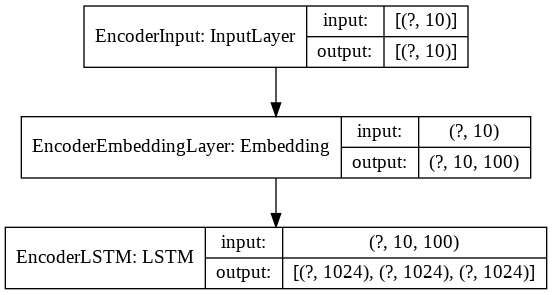

In [ ]:
# The encoder input layer and final states are used to generate the model.
encoder_model = Model(encoder_input, encoder_states)

# Plot model to be used for predictions.
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True, show_layer_names=True)
Image('/content/encoder_model.png')

### 2.2. Creating the decoder

#### 2.2.1. Creating the decoder output for accuracy determination

##### The decoder has two inputs: the hidden/cell states that were calculated from the encoder (to be put into the LSTM) and the translated sentence with the "begin" token at the beginning.

In [ ]:
# The input/embedding layers are created.
decoder_input = Input(shape=(max_output_length,), name='DecoderInput')
decoder_embedding = Embedding(translated_word_count, 1024, name='DecoderEmbeddingLayer')

# The input is plugged into the embedding layer to receive "x".
decoder_input_x = decoder_embedding(decoder_input)

# The decoder LSTM is created and the "x" is plugged into it to receive the output.
decoder_LSTM = LSTM(1024, return_state=True, return_sequences=True, name='DecoderLSTM')
decoder_output, _, _ = decoder_LSTM(decoder_input_x, initial_state=encoder_states)

# The decoder LSTM is also passed through dense layers for output predictions.
decoder_dense = Dense(1024, activation='relu', name='DenseLayer') 
decoder_dense_softmax = Dense(translated_word_count, activation='softmax', name='DenseSoftmaxLayer')

decoder_output = decoder_dense(decoder_output)
decoder_output = decoder_dense_softmax(decoder_output)

#### 2.2.2. Creating the decoder prediction model

##### The decoder model is made slightly differently; it is made so that a single word can pass through the model at a time. In addition, ***input initial layers of h and c*** are plugged into the decoder prediction model, not the encoder h and c states. The decoder states must be needed at each step for predictions to determine future words, so the model is changed for decoder to accept h and c states for each step. The embedding, LSTM, and dense layers are the same as the ones previously defined.

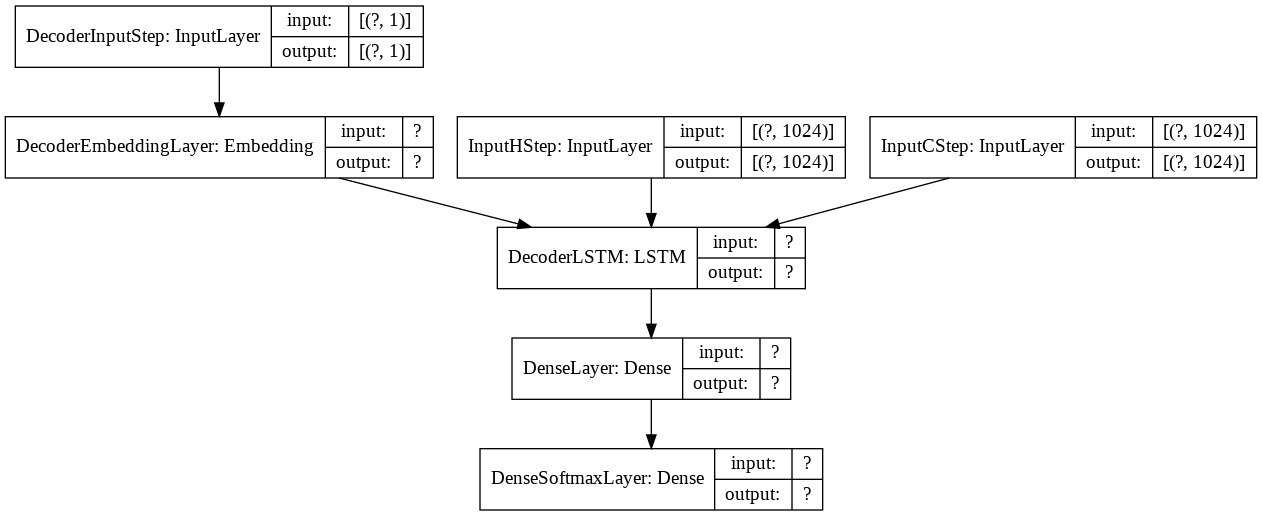

In [ ]:
# Initial h/c input layers are generated and put into an array.
decoder_state_input_h = Input(shape=(1024,), name='InputHStep')
decoder_state_input_c = Input(shape=(1024,), name='InputCStep')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# The decoder must accept a single word for the input layer as it loops through the sentence.
decoder_input_step = Input(shape=(1,), name='DecoderInputStep')
decoder_input_x_step = decoder_embedding(decoder_input_step)
decoder_output_step, h, c = decoder_LSTM(decoder_input_x_step, initial_state=decoder_states_inputs)

# The final states are put into an array.
decoder_states = [h, c]

# The decoder output for the step is put into two dense layers.
decoder_output_step = decoder_dense(decoder_output_step)
decoder_output_step = decoder_dense_softmax(decoder_output_step)

# The decoder model is created.
decoder_model = Model(
    [decoder_input_step] + decoder_states_inputs, # initial input step AND initial h/c layers 
    [decoder_output_step] + decoder_states # output input step AND output h/c from decoder LSTM 
)

# Plot model to be used for predictions.
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True, show_layer_names=True)
Image('/content/decoder_model.png')

### 2.3. Create accuracy model

#### This model is used to generate an accuracy measurement. It accepts the encoder and decoder inputs layers for the input (as an array of inputs) and the decoder LSTM output as the output.

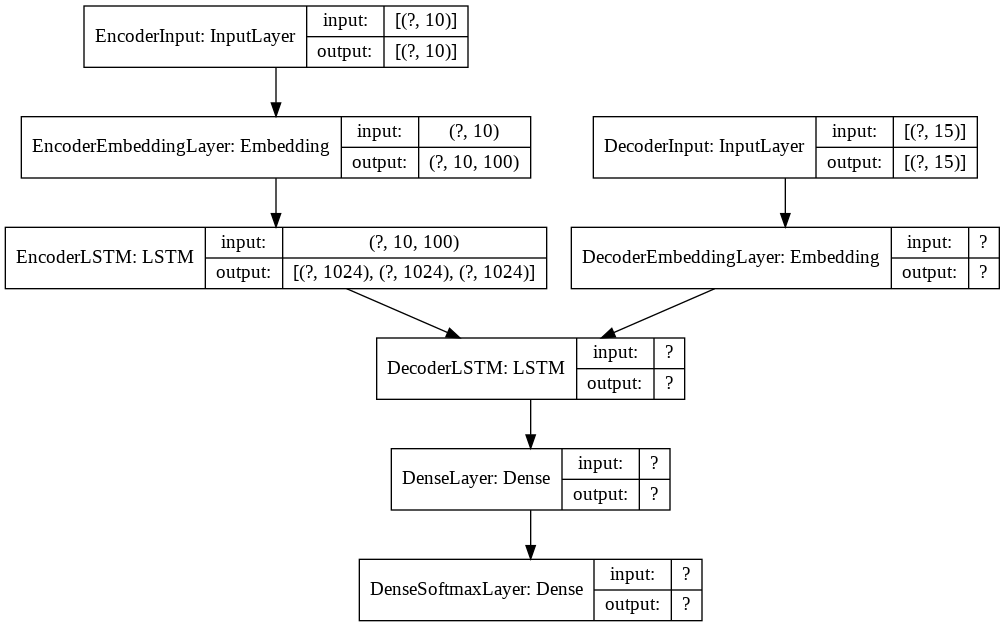

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

accuracy_model = Model([encoder_input, decoder_input], decoder_output)

# Plot accuracy model.
plot_model(accuracy_model, to_file='accuracy_model.png', show_shapes=True, show_layer_names=True)
Image('/content/accuracy_model.png')

#### Compile the accuracy model and fit it to the encoder/decoder input sequences.

In [ ]:
accuracy_model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

r = accuracy_model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_OHE,
    batch_size=16,
    epochs=10,
    validation_split=0.1,
)

Epoch 1/10
2250/2250 [==============================] - 111s 49ms/step - loss: 1.5180 - accuracy: 0.7728 - val_loss: 2.0776 - val_accuracy: 0.6831
Epoch 2/10
2250/2250 [==============================] - 110s 49ms/step - loss: 1.1019 - accuracy: 0.8246 - val_loss: 1.8588 - val_accuracy: 0.7127
Epoch 3/10
2250/2250 [==============================] - 110s 49ms/step - loss: 0.9298 - accuracy: 0.8484 - val_loss: 1.7426 - val_accuracy: 0.7301
Epoch 4/10
2250/2250 [==============================] - 110s 49ms/step - loss: 0.8152 - accuracy: 0.8663 - val_loss: 1.7168 - val_accuracy: 0.7407
Epoch 5/10
2250/2250 [==============================] - 110s 49ms/step - loss: 0.7267 - accuracy: 0.8810 - val_loss: 1.7450 - val_accuracy: 0.7455
Epoch 6/10
2250/2250 [==============================] - 111s 49ms/step - loss: 0.6576 - accuracy: 0.8920 - val_loss: 1.7706 - val_accuracy: 0.7490
Epoch 7/10
2250/2250 [==============================] - 110s 49ms/step - loss: 0.6019 - accuracy: 0.9014 - val_loss: 1

#### Plot accuracy/loss over epochs.

Text(0.5, 1.0, 'Loss')

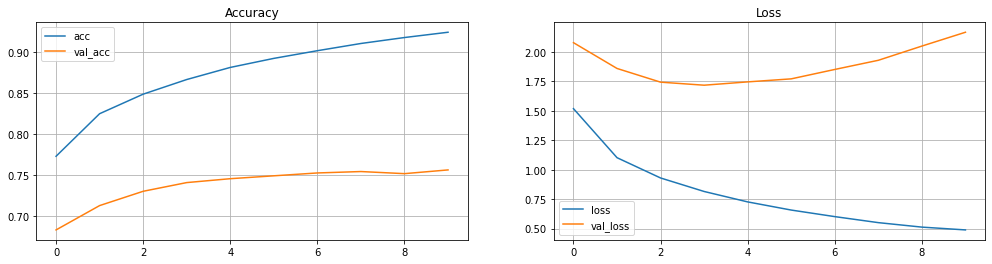

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy/val_accuracy and loss/val_loss.
fig = plt.figure(figsize = (17, 4))
    
# Pull accuracy, val_accuracy, loss, and val_loss data from r.history.
plt.subplot(121)
plt.plot(r.history['accuracy'], label = 'acc')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'Accuracy')

plt.subplot(122)
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'Loss')

## 3. Making predictions

### 3.1. Flip word/translated word dictionaries

#### Because raw sequences of numbers will be worked with, both the word_index_dict and translated_word_index_dict are flipped to have indices as keys and the specific words as values.

In [ ]:
index_word_dict = {i:w for w,i in word_index_dict.items()}
index_translated_word_dict = {i:w for w,i in translated_word_index_dict.items()}

### 3.2. Translate the sentence

#### The function to translate the sentence is created. It goes through a variety of steps to translate the sentence. It accepts an input sequence and predicts initial state values of h/c. It continues to loop through the sequence (starting with the starting token) and goes until either the end token is encountered in the output softmax identity array (i.e. when the index of the **max** value in the softmax array is equivalent to the end token index). If the end token index is not encountered, the index is swapped with its corresponding word and added to the output sentence. The new target sequence becomes the index that was found via np.argmax and the h/c values are stored and plugged back into the decoder with the target sequence to repeat until the loop ends. 

In [ ]:
def translate_sentence(input_seq):
    # Returns the initial h/c values that are generated with the input sequence.
    states_values = encoder_model.predict(input_seq)

    # Returns the start token index and puts it in the target_seq to initiate. 
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = translated_word_index_dict['走']

    # Assigns the end token index to a variable and stops the following for
    # loop once it reaches this eos value.
    eos = translated_word_index_dict['停']

    # Each word in the output is first added to an output_sentence list.
    output_sentence = []

    # Loops through an indefinite sentence length up until the maximum sentence length.
    for _ in range(max_output_length):
        # Returns predicted output sequence and h/c values.
        output_seq, h, c = decoder_model.predict([target_seq] + states_values)

        # Returns the index of the largest value in softmax identity array.
        idx = np.argmax(output_seq[0, 0])
        if eos == idx: # if the index is equal to the end token, it stops the loop
            break

        word = ''

        if idx > 0: # if the index is not padding (designated as index of 0)
            word = index_translated_word_dict[idx]
            output_sentence.append(word)

        # The index becomes the next sequence plugged into the decoder again.
        # The states values are also saved and plugged into the decoder as well.
        target_seq[0, 0] = idx
        states_values = [h, c]

    # Returns the output sentence as a string.
    return ' '.join(output_sentence)

### 3.3. Example translations

#### Random sentences from the dataset are taken and put into the translate_sentence function defined before. In addition, the translated sentence is then put through Google Translate to have a rough idea of what the translated sentence is.

In [ ]:
!pip install -q googletrans
from googletrans import Translator

In [ ]:
# Loops through given amount of sample sequences.
count = 1
for _ in range(5):
    print(f'Translation {count}: ')
    i = np.random.choice(len(input_sentences))
    input_seq = encoder_input_sequences[i:i+1]
    translation = translate_sentence(input_seq)

    translator = Translator()
    translated = translator.translate(translation)

    print('Input:', input_sentences[i])
    print('Response:', translation)
    print('Google Translate on Response:', translated.text)
    print('')
    count += 1

Translation 1: 
Input: Im bored
Response: ik verveel me
Google Translate on Response: I am bored

Translation 2: 
Input: Its raining again
Response: het is weer aan het regenen
Google Translate on Response: it is raining again

Translation 3: 
Input: Please wait here
Response: wacht hier alsjeblieft
Google Translate on Response: please wait here

Translation 4: 
Input: Is Tom free now
Response: is tom nu vrij
Google Translate on Response: tom is now free

Translation 5: 
Input: It obviously wasnt an accident
Response: het was duidelijk geen ongeluk
Google Translate on Response: it was clearly not an accident



### 3.4. Custom translation

#### Before any new sentences can be translated, they must go through the same process as our original dataset; they additionally must be padded to the max length of sentences put into training the model as well. The raw sentence is plugged into the prepare_sequence function which is then plugged into the translate_sentence function.

In [ ]:
def prepare_sequence(sentence):
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence_array = sentence.rstrip().lower().split(' ')
    sentence_sequence = [word_index_dict[word] for word in sentence_array if word in word_index_dict.keys()]
    sentence_sequence = pad_sequences([sentence_sequence], maxlen=max_input_length)
    return sentence_sequence

In [ ]:
custom_sentences = [
    'Sure.',
    'Hello friend.',
    'Who are you?', 
    'This is really fun.',
    'Why would that be there?',
    'I am not feeling that well.',
    'My favorite colors are green and blue.',
    'I am going to visit my family tomorrow.',
    'I have been wanting to go back to college.',
    'My friend wants to visit me in a few weeks.'             
]

custom_sequences = []

for custom_sentence in custom_sentences:
    sequence = prepare_sequence(custom_sentence)
    custom_sequences.append(sequence)

for i, custom_sequence in enumerate(custom_sequences):
    translation = translate_sentence(custom_sequence)
    translator = Translator()
    translated = translator.translate(translation)

    print('Input:', custom_sentences[i])
    print('Response:', translation)
    print('Google Translate on Response:', translated.text)
    print('')

Input: Sure.
Response: echt
Google Translate on Response: really

Input: Hello friend.
Response: hallo vrouw
Google Translate on Response: hello wife

Input: Who are you?
Response: wie bent u
Google Translate on Response: who are you

Input: This is really fun.
Response: dit is heel leuk
Google Translate on Response: this is great fun

Input: Why would that be there?
Response: waarom zou dat daar zijn
Google Translate on Response: why would that be there

Input: I am not feeling that well.
Response: ik voel me niet zo goed
Google Translate on Response: I do not feel so good

Input: My favorite colors are green and blue.
Response: mijn lievelingskleur zijn blauw en blauw
Google Translate on Response: my favorite colors are blue and blue

Input: I am going to visit my family tomorrow.
Response: morgen wil ik mijn neef
Google Translate on Response: tomorrow i want my cousin

Input: I have been wanting to go back to college.
Response: ik heb net tijd om naar bed te gaan
Google Translate on

#### From this, it is shown that as the sentence length gets longer, it becomes more challenging to translate. That's because it is hard to ensure all of the relations between each of the words once the sentence gets larger.

## 4. Conclusion

### Seq2Seq is a powerful architecture that consists of both an encoder LSTM and decoder LSTM system. The data must be in numerical form first through tokenizers and padding. The encoder will encode these input English sequences and assign pre-determined word embeddings which give information not only of the word itself, but where the word is likely to be found with other words. The h and c states are extracted and are used as the initial state values for the decoder LSTM. From here, each number in the sequence is plugged into the decoder model until the end token index is predicted. The biggest shortcomings of this model are its inability to both translate larger sentences and translate languages with significant deviance to English sentence structure (e.g. Japanese). This architecture can be further improved through larger training sets with larger sentence lengths. If other languages are to be used with this model that do not adhere to English sentence structure, word embeddings that are specific to that language should be used instead.